## Necessary Imports

In [1]:
import math
import os
import json

import tensorflow as tf
import tensorflow.keras as keras

import librosa

import numpy as np
import seaborn as sns
import pandas as pd

from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBClassifier

# custom helper functions
from utils import *

RANDOM_SEED = 0

2022-05-01 21:06:25.270357: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-01 21:06:25.270399: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Load Data & Develop Test/Train Splits

In [2]:
FMA_JSON_PATH = "/storage/graham/music/fma_small_data.json"
GTZAN_JSON_PATH = "/storage/graham/music/gtzan_data.json"
MODEL_PATH = "/storage/graham/music/models/"

GTZAN_SAMPLE_RATE = 22050  # gtzan sample rate
FMA_SAMPLE_RATE = GTZAN_SAMPLE_RATE * 2  # fma sample rate
DURATION = 30  # measure in seconds

In [3]:
%%time
genres, X, y = load_mfcc_data(GTZAN_JSON_PATH)

CPU times: user 10.4 s, sys: 960 ms, total: 11.3 s
Wall time: 11.3 s


In [4]:
SPLIT = 0.3

# create train/val/test split
X_train, X_val, X_test, y_train, y_val, y_test = test_train_val_split(X, y, test_size=0.3, val_size=0.3, rseed=RANDOM_SEED)

# reshape MFCC to be a vector
X_train_vec = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test_vec = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

X_vec = X.reshape(X.shape[0], X.shape[1]*X.shape[2])

## Data Visualization with t-SNE

In [5]:
%%time
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(X_vec)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 9986 samples in 0.056s...


/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:94: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn("The default initialization in TSNE will change "
/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/daal4py/sklearn/manifold/_t_sne.py:110: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn("The default learning rate in TSNE will change "


[t-SNE] Computed neighbors for 9986 samples in 0.671s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9986
[t-SNE] Computed conditional probabilities for sample 2000 / 9986
[t-SNE] Computed conditional probabilities for sample 3000 / 9986
[t-SNE] Computed conditional probabilities for sample 4000 / 9986
[t-SNE] Computed conditional probabilities for sample 5000 / 9986
[t-SNE] Computed conditional probabilities for sample 6000 / 9986
[t-SNE] Computed conditional probabilities for sample 7000 / 9986
[t-SNE] Computed conditional probabilities for sample 8000 / 9986
[t-SNE] Computed conditional probabilities for sample 9000 / 9986
[t-SNE] Computed conditional probabilities for sample 9986 / 9986
[t-SNE] Mean sigma: 255.320316
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.800880
[t-SNE] KL divergence after 1000 iterations: 2.182292
CPU times: user 1h 55min 48s, sys: 4min 15s, total: 2h 4s
Wall time: 36.7 s


<Figure size 1728x1296 with 0 Axes>

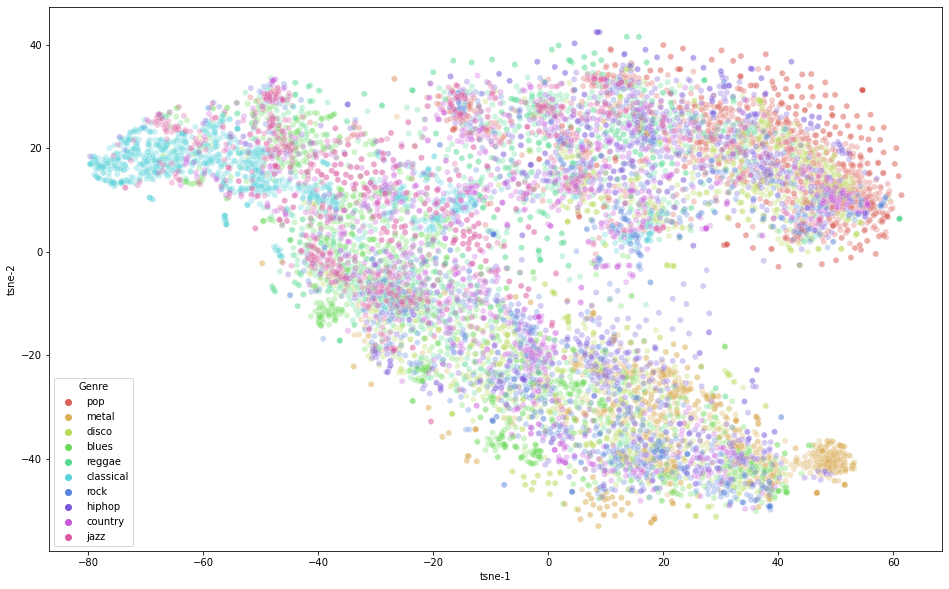

In [6]:
df_subset=pd.DataFrame()
df_subset['tsne-1'] = tsne_results[:,0]
df_subset['tsne-2'] = tsne_results[:,1]

# apply labels
labs = [genres[x] for x in y]
df_subset['Genre'] = labs

plt.figure(figsize=(24,18))
plt.figure(figsize=(16,10))
sns.scatterplot(x='tsne-1', 
                y='tsne-2',
                hue='Genre',
                palette=sns.color_palette('hls', len(genres)), 
                data=df_subset, 
                legend='full', 
                alpha=0.3
)
plt.show()

## Train Classical Models

### K-Nearest Neighbors Classifier

In [7]:
%%time
KNNmodel = KNeighborsClassifier(n_neighbors=10)
KNNmodel.fit(X_train_vec,y_train)
y_pred_knn = KNNmodel.predict(X_test_vec)

print_report(y_test, y_pred_knn)

Accuracy Score is:	 0.367
              precision    recall  f1-score   support

           0       0.60      0.27      0.38       289
           1       0.41      0.88      0.56       293
           2       0.42      0.12      0.19       313
           3       0.64      0.26      0.37       284
           4       0.78      0.02      0.04       309
           5       0.58      0.95      0.72       310
           6       0.27      0.29      0.28       314
           7       0.67      0.05      0.09       296
           8       0.22      0.24      0.23       312
           9       0.21      0.62      0.31       276

    accuracy                           0.37      2996
   macro avg       0.48      0.37      0.32      2996
weighted avg       0.48      0.37      0.32      2996

[[ 79   3  29   0   0   5  19   0  88  66]
 [  0 257   1   3   0   1  20   0   0  11]
 [ 10  69  39   9   0   7  70   1  61  47]
 [  0  68   1  74   0  33  26   0   5  77]
 [ 13  14   7  11   7  12  35   5  27 178]


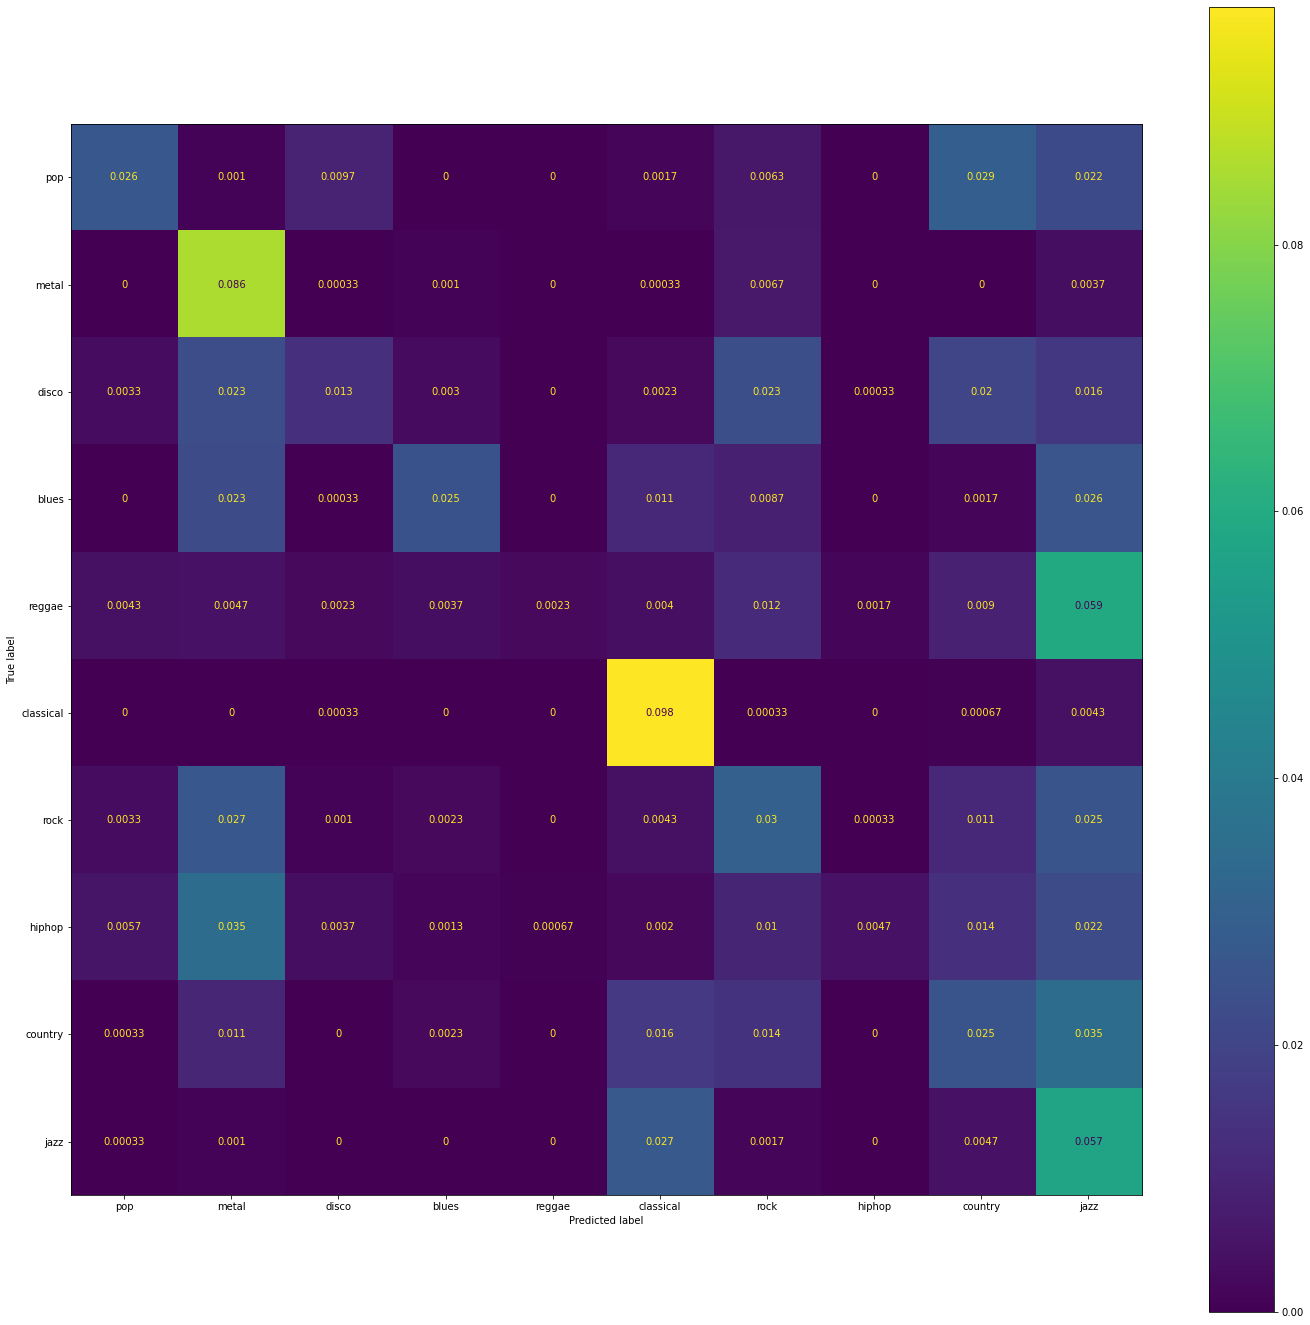

In [8]:
cm = confusion_matrix(y_test, y_pred_knn, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Support Vector Machine Classifier

In [9]:
%%time
SVMmodel = SVC()
SVMmodel.fit(X_train_vec,y_train)
y_pred_svm =  SVMmodel.predict(X_test_vec)

print_report(y_test, y_pred_svm)

Accuracy Score is:	 0.529
              precision    recall  f1-score   support

           0       0.51      0.82      0.63       289
           1       0.61      0.82      0.70       293
           2       0.40      0.36      0.38       313
           3       0.49      0.37      0.42       284
           4       0.55      0.51      0.53       309
           5       0.80      0.87      0.83       310
           6       0.37      0.33      0.35       314
           7       0.47      0.34      0.40       296
           8       0.46      0.28      0.35       312
           9       0.51      0.62      0.56       276

    accuracy                           0.53      2996
   macro avg       0.52      0.53      0.51      2996
weighted avg       0.52      0.53      0.51      2996

[[236   0  11   1   7   3   0  12   7  12]
 [  0 240   7  10   9   0   8  15   2   2]
 [ 76  22 112  13  20   3  44  18   5   0]
 [  0  50  14 105  10  13  43   2  18  29]
 [ 31   2  19  11 157   2  10  48  15  14]


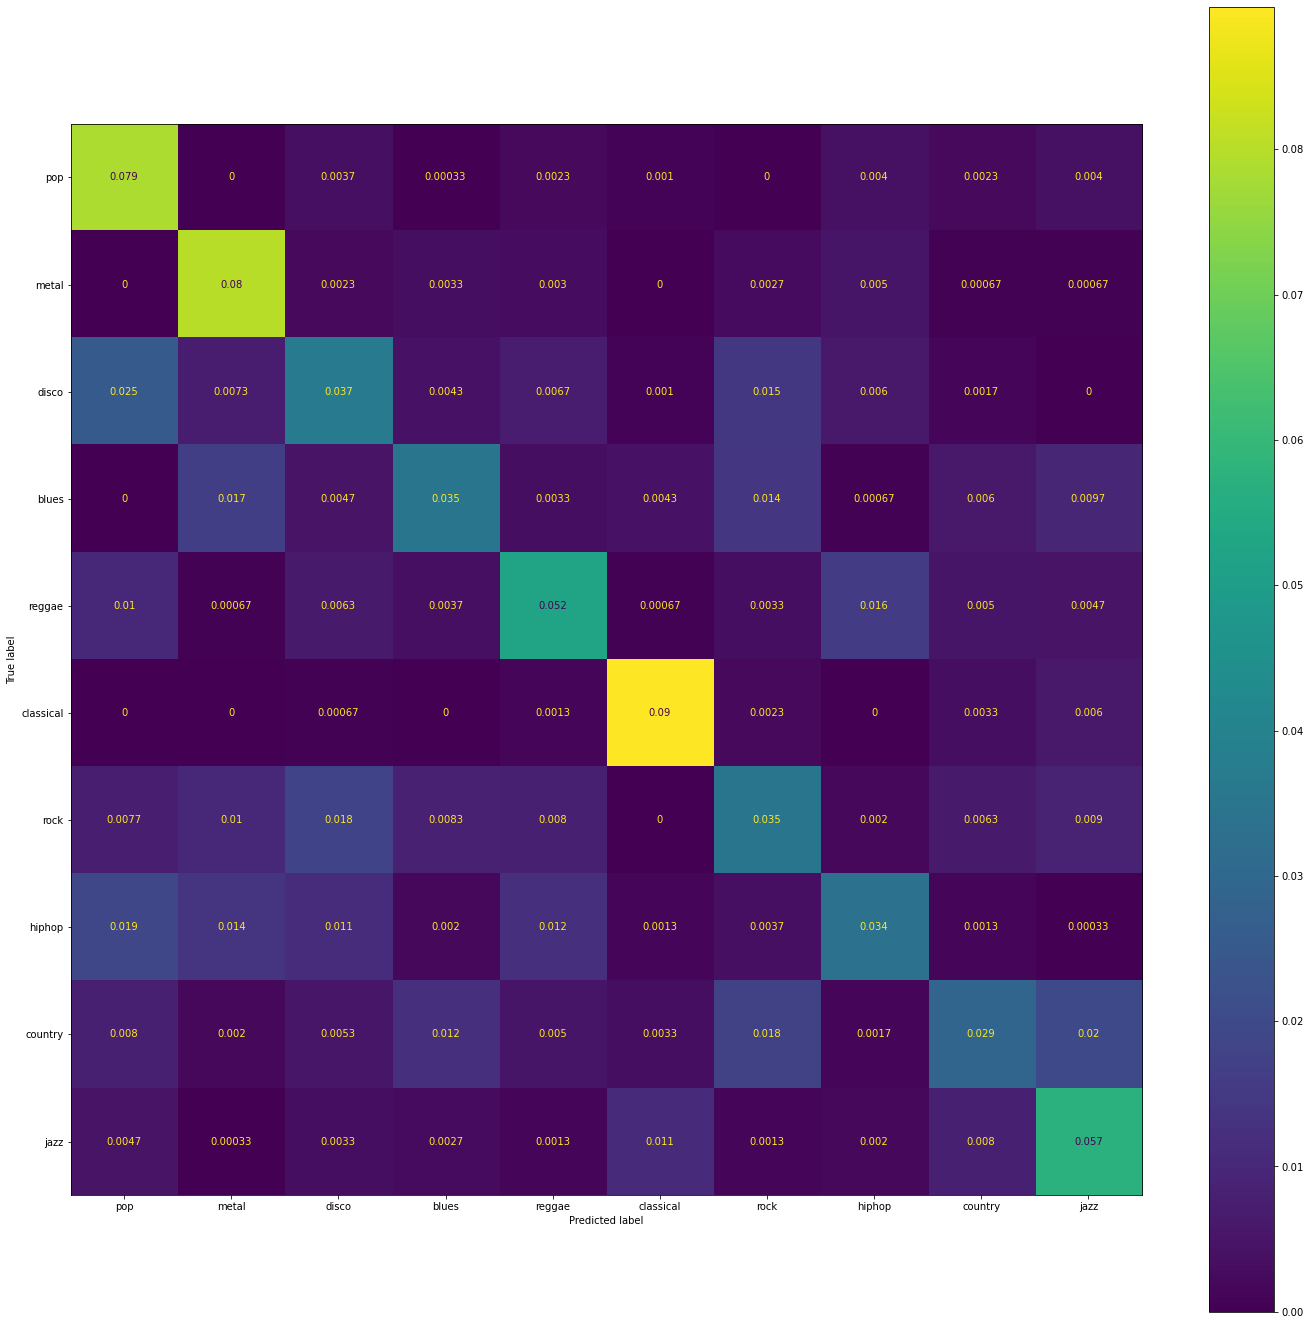

In [10]:
cm = confusion_matrix(y_test, y_pred_svm, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Decision Tree Classifier

In [11]:
%%time
DTmodel = DecisionTreeClassifier()
DTmodel.fit(X_train_vec, y_train)
y_pred_dt =  DTmodel.predict(X_test_vec)

print_report(y_test, y_pred_dt)

Accuracy Score is:	 0.343
              precision    recall  f1-score   support

           0       0.47      0.45      0.46       289
           1       0.49      0.49      0.49       293
           2       0.26      0.26      0.26       313
           3       0.24      0.23      0.24       284
           4       0.31      0.24      0.27       309
           5       0.68      0.72      0.70       310
           6       0.20      0.22      0.21       314
           7       0.24      0.26      0.25       296
           8       0.21      0.20      0.20       312
           9       0.33      0.36      0.35       276

    accuracy                           0.34      2996
   macro avg       0.34      0.34      0.34      2996
weighted avg       0.34      0.34      0.34      2996

[[130   4  30   7  16   5  23  33  26  15]
 [  2 144  23  34   4   1  38  34  10   3]
 [ 28  25  81  19  17   8  44  37  34  20]
 [  2  31  24  65  21  13  36  25  30  37]
 [ 28  14  27  17  73   8  33  50  33  26]


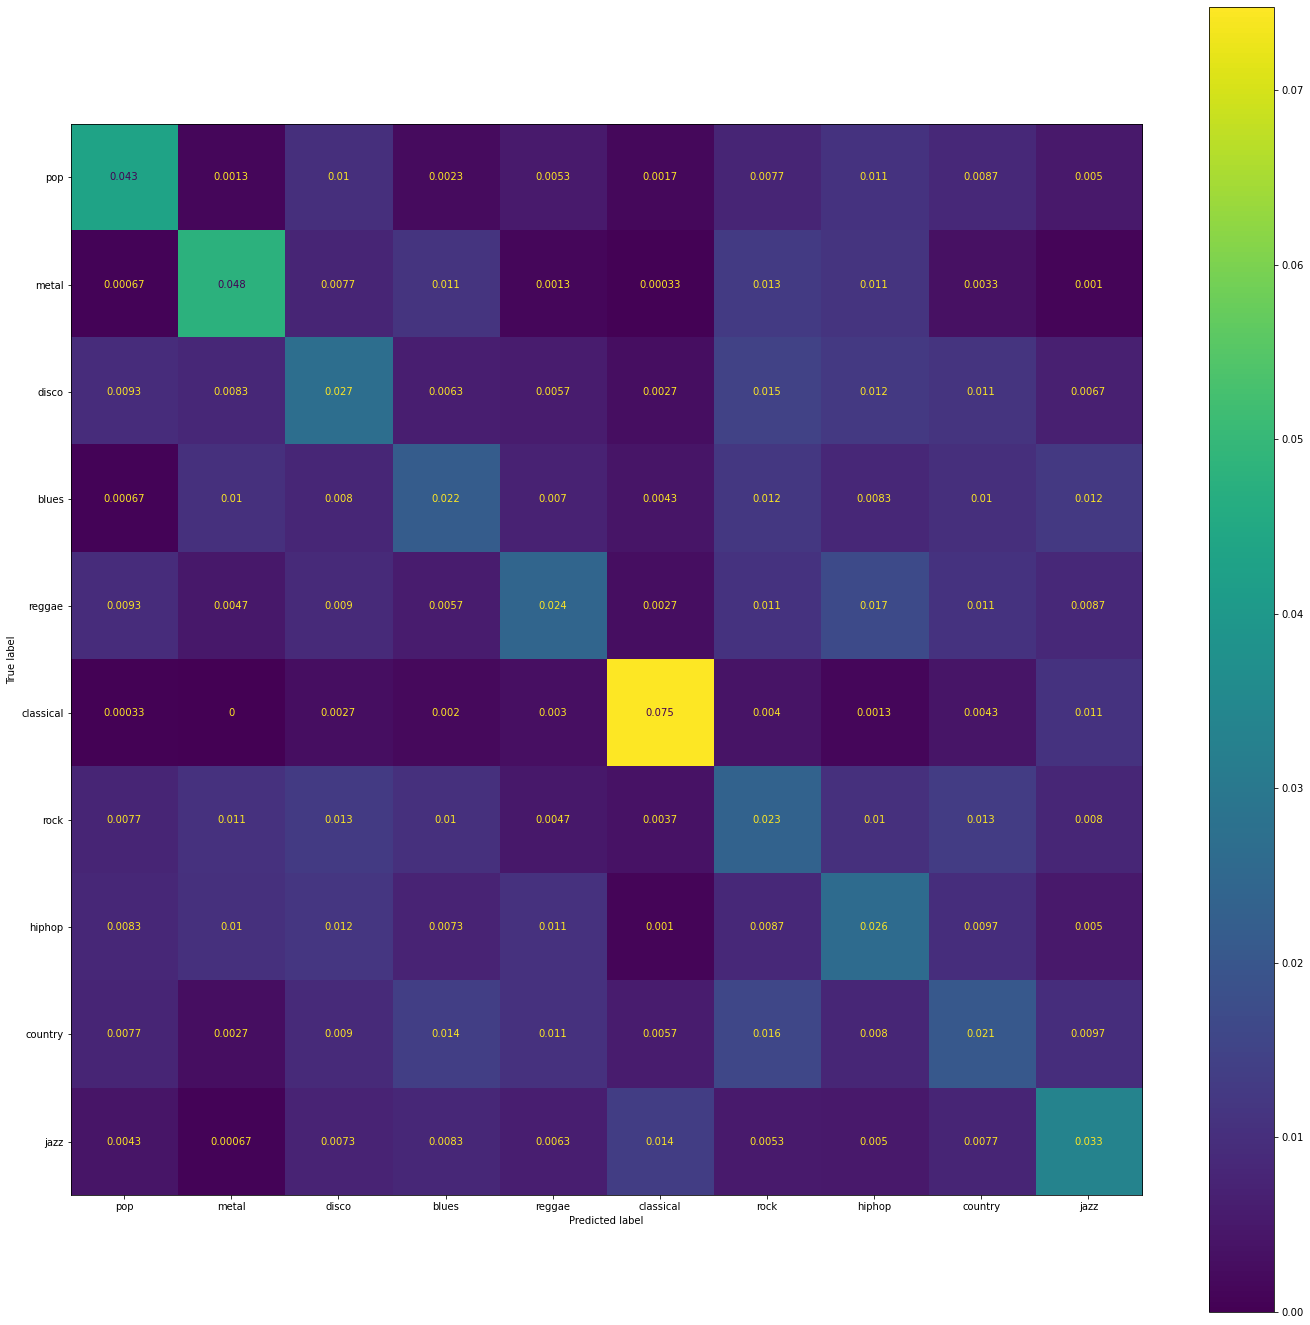

In [12]:
cm = confusion_matrix(y_test, y_pred_dt, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

### Gradient Boosted Classifier

In [13]:
%%time
XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_vec, y_train)
y_pred_xgb =  XGBmodel.predict(X_test_vec)

print_report(y_test, y_pred_xgb)

/storage/graham/miniconda3/envs/music/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:07:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score is:	 0.585
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       289
           1       0.70      0.80      0.74       293
           2       0.48      0.46      0.47       313
           3       0.60      0.55      0.57       284
           4       0.57      0.50      0.53       309
           5       0.82      0.89      0.85       310
           6       0.45      0.42      0.43       314
           7       0.49      0.39      0.43       296
           8       0.48      0.42      0.45       312
           9       0.56      0.70      0.62       276

    accuracy                           0.59      2996
   macro avg       0.58      0.59      0.58      2996
weighted avg     

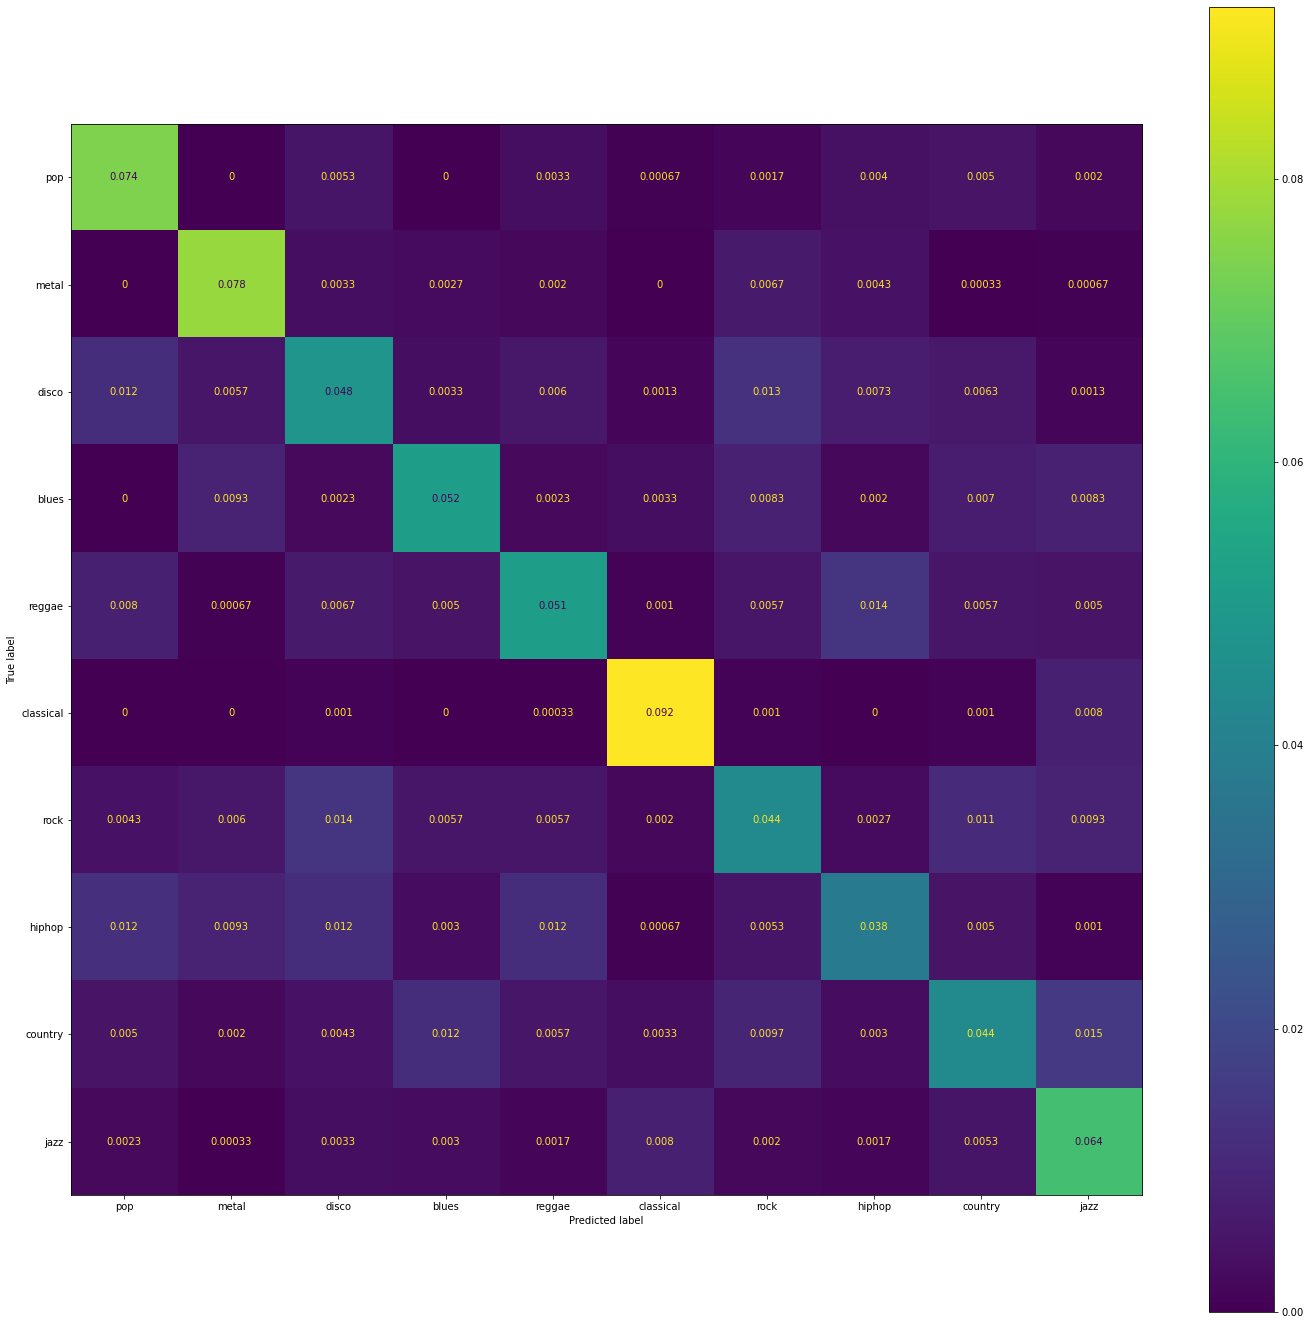

In [14]:
cm = confusion_matrix(y_test, y_pred_xgb, normalize='all')
cmd = ConfusionMatrixDisplay(cm, display_labels=genres)
fig, ax = plt.subplots(figsize=(24,24))
cmd.plot(ax=ax)

## Deep Learning Methods

### Fully Connected Neural Network (Multi-Layer Perceptron)

In [15]:
%%time
# build network topology
mlp = keras.Sequential([

    # input layer
    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    # 1st dense layer
    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 2nd dense layer
    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # 3rd dense layer
    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    # output layer
    keras.layers.Dense(len(genres), activation='softmax')
])

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
mlp.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

mlp.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/gtzan_mlp/"
saveBest, es, lr = setup_callbacks(mlp, MODEL_SAVE_PATH)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1690)              0         
                                                                 
 dense (Dense)               (None, 512)               865792    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0

2022-05-01 21:07:43.451683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-05-01 21:07:43.451721: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-05-01 21:07:43.451743: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (earhart): /proc/driver/nvidia/version does not exist
2022-05-01 21:07:43.452037: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100
150/153 [============================>.] - ETA: 0s - loss: 30.4699 - accuracy: 0.1631
Epoch 1: val_loss improved from inf to 4.17182, saving model to /storage/graham/music/models//gtzan_mlp/


2022-05-01 21:07:45.390034: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 30.1564 - accuracy: 0.1635 - val_loss: 4.1718 - val_accuracy: 0.2761 - lr: 1.0000e-04
Epoch 2/100
153/153 [==============================] - ETA: 0s - loss: 9.2350 - accuracy: 0.1821
Epoch 2: val_loss improved from 4.17182 to 3.43506, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 9.2350 - accuracy: 0.1821 - val_loss: 3.4351 - val_accuracy: 0.1979 - lr: 1.0000e-04
Epoch 3/100
145/153 [===========================>..] - ETA: 0s - loss: 5.7809 - accuracy: 0.1748
Epoch 3: val_loss improved from 3.43506 to 3.41737, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 5.7107 - accuracy: 0.1743 - val_loss: 3.4174 - val_accuracy: 0.1822 - lr: 1.0000e-04
Epoch 4/100
147/153 [===========================>..] - ETA: 0s - loss: 4.5625 - accuracy: 0.1645
Epoch 4: val_loss did not improve from 3.41737
153/153 [==============================] - 1s 7ms/step - loss: 4.5555 - accuracy: 0.1643 - val_loss: 3.4280 - val_accuracy: 0.1598 - lr: 1.0000e-04
Epoch 5/100
145/153 [===========================>..] - ETA: 0s - loss: 4.0636 - accuracy: 0.1653
Epoch 5: val_loss did not improve from 3.41737
153/153 [==============================] - 1s 7ms/step - loss: 4.0471 - accuracy: 0.1664 - val_loss: 3.4287 - val_accuracy: 0.1617 - lr: 1.0000e-04
Epoch 6/100
149/153 [============================>.] - ETA: 0s - loss: 3.8343 - accuracy: 0.1527
Epoch 6: val_loss did not improve from 3.41737
153/153 [==============================] - 1s 7ms/step - loss: 3.8331 - accuracy: 0.1531 - val_loss: 3.4258 - val_accuracy:

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.6450 - accuracy: 0.1543 - val_loss: 3.3913 - val_accuracy: 0.1617 - lr: 1.0000e-04
Epoch 9/100
148/153 [============================>.] - ETA: 0s - loss: 3.5530 - accuracy: 0.1715
Epoch 9: val_loss improved from 3.39130 to 3.36864, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.5514 - accuracy: 0.1713 - val_loss: 3.3686 - val_accuracy: 0.2031 - lr: 1.0000e-04
Epoch 10/100
145/153 [===========================>..] - ETA: 0s - loss: 3.5031 - accuracy: 0.1929
Epoch 10: val_loss improved from 3.36864 to 3.35662, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.5044 - accuracy: 0.1927 - val_loss: 3.3566 - val_accuracy: 0.2003 - lr: 1.0000e-04
Epoch 11/100
151/153 [============================>.] - ETA: 0s - loss: 3.4919 - accuracy: 0.1939
Epoch 11: val_loss improved from 3.35662 to 3.34585, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 3.4924 - accuracy: 0.1933 - val_loss: 3.3458 - val_accuracy: 0.2060 - lr: 1.0000e-04
Epoch 12/100
149/153 [============================>.] - ETA: 0s - loss: 3.4516 - accuracy: 0.2039
Epoch 12: val_loss improved from 3.34585 to 3.33878, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.4523 - accuracy: 0.2029 - val_loss: 3.3388 - val_accuracy: 0.2070 - lr: 1.0000e-04
Epoch 13/100
147/153 [===========================>..] - ETA: 0s - loss: 3.4053 - accuracy: 0.2000
Epoch 13: val_loss improved from 3.33878 to 3.31171, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.4041 - accuracy: 0.2021 - val_loss: 3.3117 - val_accuracy: 0.2165 - lr: 1.0000e-04
Epoch 14/100
151/153 [============================>.] - ETA: 0s - loss: 3.3865 - accuracy: 0.2082
Epoch 14: val_loss did not improve from 3.31171
153/153 [==============================] - 1s 7ms/step - loss: 3.3857 - accuracy: 0.2068 - val_loss: 3.3138 - val_accuracy: 0.2141 - lr: 1.0000e-04
Epoch 15/100
147/153 [===========================>..] - ETA: 0s - loss: 3.3410 - accuracy: 0.2224
Epoch 15: val_loss improved from 3.31171 to 3.26153, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.3394 - accuracy: 0.2222 - val_loss: 3.2615 - val_accuracy: 0.2375 - lr: 1.0000e-04
Epoch 16/100
147/153 [===========================>..] - ETA: 0s - loss: 3.3497 - accuracy: 0.2185
Epoch 16: val_loss improved from 3.26153 to 3.22196, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.3474 - accuracy: 0.2226 - val_loss: 3.2220 - val_accuracy: 0.2475 - lr: 1.0000e-04
Epoch 17/100
147/153 [===========================>..] - ETA: 0s - loss: 3.3002 - accuracy: 0.2321
Epoch 17: val_loss improved from 3.22196 to 3.20629, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 14ms/step - loss: 3.2998 - accuracy: 0.2328 - val_loss: 3.2063 - val_accuracy: 0.2566 - lr: 1.0000e-04
Epoch 18/100
152/153 [============================>.] - ETA: 0s - loss: 3.2808 - accuracy: 0.2354
Epoch 18: val_loss did not improve from 3.20629
153/153 [==============================] - 1s 8ms/step - loss: 3.2818 - accuracy: 0.2346 - val_loss: 3.2200 - val_accuracy: 0.2475 - lr: 1.0000e-04
Epoch 19/100
145/153 [===========================>..] - ETA: 0s - loss: 3.2598 - accuracy: 0.2319
Epoch 19: val_loss did not improve from 3.20629
153/153 [==============================] - 1s 7ms/step - loss: 3.2629 - accuracy: 0.2307 - val_loss: 3.2124 - val_accuracy: 0.2418 - lr: 1.0000e-04
Epoch 20/100
145/153 [===========================>..] - ETA: 0s - loss: 3.2474 - accuracy: 0.2319
Epoch 20: val_loss improved from 3.20629 to 3.19725, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2485 - accuracy: 0.2316 - val_loss: 3.1972 - val_accuracy: 0.2508 - lr: 1.0000e-04
Epoch 21/100
146/153 [===========================>..] - ETA: 0s - loss: 3.2487 - accuracy: 0.2314
Epoch 21: val_loss improved from 3.19725 to 3.18981, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2471 - accuracy: 0.2316 - val_loss: 3.1898 - val_accuracy: 0.2480 - lr: 1.0000e-04
Epoch 22/100
146/153 [===========================>..] - ETA: 0s - loss: 3.2418 - accuracy: 0.2391
Epoch 22: val_loss improved from 3.18981 to 3.15561, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2439 - accuracy: 0.2379 - val_loss: 3.1556 - val_accuracy: 0.2632 - lr: 1.0000e-04
Epoch 23/100
147/153 [===========================>..] - ETA: 0s - loss: 3.2168 - accuracy: 0.2358
Epoch 23: val_loss improved from 3.15561 to 3.13969, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.2113 - accuracy: 0.2367 - val_loss: 3.1397 - val_accuracy: 0.2585 - lr: 1.0000e-04
Epoch 24/100
150/153 [============================>.] - ETA: 0s - loss: 3.1994 - accuracy: 0.2427
Epoch 24: val_loss improved from 3.13969 to 3.11775, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.1968 - accuracy: 0.2430 - val_loss: 3.1178 - val_accuracy: 0.2647 - lr: 1.0000e-04
Epoch 25/100
149/153 [============================>.] - ETA: 0s - loss: 3.1600 - accuracy: 0.2506
Epoch 25: val_loss did not improve from 3.11775
153/153 [==============================] - 1s 7ms/step - loss: 3.1608 - accuracy: 0.2506 - val_loss: 3.1533 - val_accuracy: 0.2542 - lr: 1.0000e-04
Epoch 26/100
145/153 [===========================>..] - ETA: 0s - loss: 3.1465 - accuracy: 0.2498
Epoch 26: val_loss improved from 3.11775 to 3.09637, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 3.1397 - accuracy: 0.2530 - val_loss: 3.0964 - val_accuracy: 0.2723 - lr: 1.0000e-04
Epoch 27/100
149/153 [============================>.] - ETA: 0s - loss: 3.1117 - accuracy: 0.2521
Epoch 27: val_loss improved from 3.09637 to 3.07971, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.1122 - accuracy: 0.2522 - val_loss: 3.0797 - val_accuracy: 0.2799 - lr: 1.0000e-04
Epoch 28/100
152/153 [============================>.] - ETA: 0s - loss: 3.1196 - accuracy: 0.2539
Epoch 28: val_loss improved from 3.07971 to 3.07888, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.1244 - accuracy: 0.2532 - val_loss: 3.0789 - val_accuracy: 0.2737 - lr: 1.0000e-04
Epoch 29/100
153/153 [==============================] - ETA: 0s - loss: 3.0995 - accuracy: 0.2614
Epoch 29: val_loss improved from 3.07888 to 3.06896, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.0995 - accuracy: 0.2614 - val_loss: 3.0690 - val_accuracy: 0.2766 - lr: 1.0000e-04
Epoch 30/100
147/153 [===========================>..] - ETA: 0s - loss: 3.0637 - accuracy: 0.2642
Epoch 30: val_loss improved from 3.06896 to 3.04800, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 3.0693 - accuracy: 0.2626 - val_loss: 3.0480 - val_accuracy: 0.2790 - lr: 1.0000e-04
Epoch 31/100
153/153 [==============================] - ETA: 0s - loss: 3.0693 - accuracy: 0.2565
Epoch 31: val_loss did not improve from 3.04800
153/153 [==============================] - 1s 8ms/step - loss: 3.0693 - accuracy: 0.2565 - val_loss: 3.0547 - val_accuracy: 0.2747 - lr: 1.0000e-04
Epoch 32/100
150/153 [============================>.] - ETA: 0s - loss: 3.0496 - accuracy: 0.2619
Epoch 32: val_loss improved from 3.04800 to 3.04218, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.0515 - accuracy: 0.2610 - val_loss: 3.0422 - val_accuracy: 0.2856 - lr: 1.0000e-04
Epoch 33/100
148/153 [============================>.] - ETA: 0s - loss: 3.0375 - accuracy: 0.2646
Epoch 33: val_loss improved from 3.04218 to 3.03388, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.0395 - accuracy: 0.2649 - val_loss: 3.0339 - val_accuracy: 0.2866 - lr: 1.0000e-04
Epoch 34/100
151/153 [============================>.] - ETA: 0s - loss: 3.0153 - accuracy: 0.2647
Epoch 34: val_loss improved from 3.03388 to 3.02364, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 3.0130 - accuracy: 0.2651 - val_loss: 3.0236 - val_accuracy: 0.2866 - lr: 1.0000e-04
Epoch 35/100
145/153 [===========================>..] - ETA: 0s - loss: 3.0044 - accuracy: 0.2679
Epoch 35: val_loss improved from 3.02364 to 3.00460, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 3.0086 - accuracy: 0.2651 - val_loss: 3.0046 - val_accuracy: 0.2771 - lr: 1.0000e-04
Epoch 36/100
152/153 [============================>.] - ETA: 0s - loss: 2.9904 - accuracy: 0.2724
Epoch 36: val_loss improved from 3.00460 to 2.97317, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.9901 - accuracy: 0.2724 - val_loss: 2.9732 - val_accuracy: 0.2823 - lr: 1.0000e-04
Epoch 37/100
147/153 [===========================>..] - ETA: 0s - loss: 2.9671 - accuracy: 0.2719
Epoch 37: val_loss improved from 2.97317 to 2.96698, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.9679 - accuracy: 0.2718 - val_loss: 2.9670 - val_accuracy: 0.2866 - lr: 1.0000e-04
Epoch 38/100
153/153 [==============================] - ETA: 0s - loss: 2.9602 - accuracy: 0.2743
Epoch 38: val_loss improved from 2.96698 to 2.96340, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.9602 - accuracy: 0.2743 - val_loss: 2.9634 - val_accuracy: 0.2976 - lr: 1.0000e-04
Epoch 39/100
153/153 [==============================] - ETA: 0s - loss: 2.9523 - accuracy: 0.2694
Epoch 39: val_loss did not improve from 2.96340
153/153 [==============================] - 1s 6ms/step - loss: 2.9523 - accuracy: 0.2694 - val_loss: 2.9654 - val_accuracy: 0.2961 - lr: 1.0000e-04
Epoch 40/100
145/153 [===========================>..] - ETA: 0s - loss: 2.8840 - accuracy: 0.2862
Epoch 40: val_loss improved from 2.96340 to 2.93921, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8869 - accuracy: 0.2865 - val_loss: 2.9392 - val_accuracy: 0.3019 - lr: 1.0000e-04
Epoch 41/100
145/153 [===========================>..] - ETA: 0s - loss: 2.8897 - accuracy: 0.2944
Epoch 41: val_loss improved from 2.93921 to 2.90926, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.8878 - accuracy: 0.2959 - val_loss: 2.9093 - val_accuracy: 0.2923 - lr: 1.0000e-04
Epoch 42/100
146/153 [===========================>..] - ETA: 0s - loss: 2.8630 - accuracy: 0.2862
Epoch 42: val_loss improved from 2.90926 to 2.88875, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.8671 - accuracy: 0.2847 - val_loss: 2.8887 - val_accuracy: 0.2947 - lr: 1.0000e-04
Epoch 43/100
148/153 [============================>.] - ETA: 0s - loss: 2.8452 - accuracy: 0.2958
Epoch 43: val_loss improved from 2.88875 to 2.87738, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8429 - accuracy: 0.2949 - val_loss: 2.8774 - val_accuracy: 0.3028 - lr: 1.0000e-04
Epoch 44/100
147/153 [===========================>..] - ETA: 0s - loss: 2.8337 - accuracy: 0.2993
Epoch 44: val_loss improved from 2.87738 to 2.86249, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.8365 - accuracy: 0.2978 - val_loss: 2.8625 - val_accuracy: 0.3114 - lr: 1.0000e-04
Epoch 45/100
149/153 [============================>.] - ETA: 0s - loss: 2.8047 - accuracy: 0.3020
Epoch 45: val_loss improved from 2.86249 to 2.83499, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.8035 - accuracy: 0.3017 - val_loss: 2.8350 - val_accuracy: 0.3157 - lr: 1.0000e-04
Epoch 46/100
147/153 [===========================>..] - ETA: 0s - loss: 2.8040 - accuracy: 0.3042
Epoch 46: val_loss improved from 2.83499 to 2.82656, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.7985 - accuracy: 0.3062 - val_loss: 2.8266 - val_accuracy: 0.3157 - lr: 1.0000e-04
Epoch 47/100
147/153 [===========================>..] - ETA: 0s - loss: 2.7544 - accuracy: 0.3153
Epoch 47: val_loss improved from 2.82656 to 2.81551, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.7556 - accuracy: 0.3129 - val_loss: 2.8155 - val_accuracy: 0.3214 - lr: 1.0000e-04
Epoch 48/100
153/153 [==============================] - ETA: 0s - loss: 2.7491 - accuracy: 0.3164
Epoch 48: val_loss improved from 2.81551 to 2.78015, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.7491 - accuracy: 0.3164 - val_loss: 2.7802 - val_accuracy: 0.3495 - lr: 1.0000e-04
Epoch 49/100
151/153 [============================>.] - ETA: 0s - loss: 2.6978 - accuracy: 0.3237
Epoch 49: val_loss improved from 2.78015 to 2.77401, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.6989 - accuracy: 0.3239 - val_loss: 2.7740 - val_accuracy: 0.3386 - lr: 1.0000e-04
Epoch 50/100
146/153 [===========================>..] - ETA: 0s - loss: 2.6902 - accuracy: 0.3275
Epoch 50: val_loss improved from 2.77401 to 2.75332, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.6899 - accuracy: 0.3264 - val_loss: 2.7533 - val_accuracy: 0.3190 - lr: 1.0000e-04
Epoch 51/100
146/153 [===========================>..] - ETA: 0s - loss: 2.6732 - accuracy: 0.3266
Epoch 51: val_loss did not improve from 2.75332
153/153 [==============================] - 1s 6ms/step - loss: 2.6783 - accuracy: 0.3241 - val_loss: 2.7675 - val_accuracy: 0.3348 - lr: 1.0000e-04
Epoch 52/100
148/153 [============================>.] - ETA: 0s - loss: 2.6539 - accuracy: 0.3256
Epoch 52: val_loss improved from 2.75332 to 2.70261, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.6548 - accuracy: 0.3260 - val_loss: 2.7026 - val_accuracy: 0.3500 - lr: 1.0000e-04
Epoch 53/100
149/153 [============================>.] - ETA: 0s - loss: 2.6298 - accuracy: 0.3404
Epoch 53: val_loss improved from 2.70261 to 2.67509, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 12ms/step - loss: 2.6289 - accuracy: 0.3397 - val_loss: 2.6751 - val_accuracy: 0.3410 - lr: 1.0000e-04
Epoch 54/100
150/153 [============================>.] - ETA: 0s - loss: 2.5852 - accuracy: 0.3406
Epoch 54: val_loss did not improve from 2.67509
153/153 [==============================] - 1s 6ms/step - loss: 2.5834 - accuracy: 0.3411 - val_loss: 2.6773 - val_accuracy: 0.3472 - lr: 1.0000e-04
Epoch 55/100
148/153 [============================>.] - ETA: 0s - loss: 2.5725 - accuracy: 0.3385
Epoch 55: val_loss improved from 2.67509 to 2.63869, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.5697 - accuracy: 0.3397 - val_loss: 2.6387 - val_accuracy: 0.3591 - lr: 1.0000e-04
Epoch 56/100
151/153 [============================>.] - ETA: 0s - loss: 2.5354 - accuracy: 0.3500
Epoch 56: val_loss improved from 2.63869 to 2.63146, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.5345 - accuracy: 0.3497 - val_loss: 2.6315 - val_accuracy: 0.3505 - lr: 1.0000e-04
Epoch 57/100
148/153 [============================>.] - ETA: 0s - loss: 2.5060 - accuracy: 0.3552
Epoch 57: val_loss improved from 2.63146 to 2.61366, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.5028 - accuracy: 0.3554 - val_loss: 2.6137 - val_accuracy: 0.3686 - lr: 1.0000e-04
Epoch 58/100
148/153 [============================>.] - ETA: 0s - loss: 2.4896 - accuracy: 0.3647
Epoch 58: val_loss improved from 2.61366 to 2.59032, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.4876 - accuracy: 0.3636 - val_loss: 2.5903 - val_accuracy: 0.3639 - lr: 1.0000e-04
Epoch 59/100
149/153 [============================>.] - ETA: 0s - loss: 2.4705 - accuracy: 0.3633
Epoch 59: val_loss did not improve from 2.59032
153/153 [==============================] - 1s 6ms/step - loss: 2.4673 - accuracy: 0.3642 - val_loss: 2.6100 - val_accuracy: 0.3548 - lr: 1.0000e-04
Epoch 60/100
150/153 [============================>.] - ETA: 0s - loss: 2.4438 - accuracy: 0.3760
Epoch 60: val_loss improved from 2.59032 to 2.57775, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.4430 - accuracy: 0.3758 - val_loss: 2.5778 - val_accuracy: 0.3681 - lr: 1.0000e-04
Epoch 61/100
146/153 [===========================>..] - ETA: 0s - loss: 2.4037 - accuracy: 0.3821
Epoch 61: val_loss improved from 2.57775 to 2.56006, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.4037 - accuracy: 0.3830 - val_loss: 2.5601 - val_accuracy: 0.3701 - lr: 1.0000e-04
Epoch 62/100
148/153 [============================>.] - ETA: 0s - loss: 2.3886 - accuracy: 0.3841
Epoch 62: val_loss improved from 2.56006 to 2.52056, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.3895 - accuracy: 0.3832 - val_loss: 2.5206 - val_accuracy: 0.3805 - lr: 1.0000e-04
Epoch 63/100
151/153 [============================>.] - ETA: 0s - loss: 2.3720 - accuracy: 0.3802
Epoch 63: val_loss improved from 2.52056 to 2.49665, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 2.3723 - accuracy: 0.3791 - val_loss: 2.4966 - val_accuracy: 0.3748 - lr: 1.0000e-04
Epoch 64/100
146/153 [===========================>..] - ETA: 0s - loss: 2.3292 - accuracy: 0.3926
Epoch 64: val_loss did not improve from 2.49665
153/153 [==============================] - 1s 6ms/step - loss: 2.3272 - accuracy: 0.3934 - val_loss: 2.5308 - val_accuracy: 0.3896 - lr: 1.0000e-04
Epoch 65/100
149/153 [============================>.] - ETA: 0s - loss: 2.3125 - accuracy: 0.4035
Epoch 65: val_loss improved from 2.49665 to 2.46632, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.3106 - accuracy: 0.4040 - val_loss: 2.4663 - val_accuracy: 0.3786 - lr: 1.0000e-04
Epoch 66/100
149/153 [============================>.] - ETA: 0s - loss: 2.3061 - accuracy: 0.3972
Epoch 66: val_loss did not improve from 2.46632
153/153 [==============================] - 1s 6ms/step - loss: 2.3060 - accuracy: 0.3959 - val_loss: 2.4794 - val_accuracy: 0.3810 - lr: 1.0000e-04
Epoch 67/100
145/153 [===========================>..] - ETA: 0s - loss: 2.2620 - accuracy: 0.4075
Epoch 67: val_loss did not improve from 2.46632
153/153 [==============================] - 1s 7ms/step - loss: 2.2622 - accuracy: 0.4090 - val_loss: 2.4737 - val_accuracy: 0.3963 - lr: 1.0000e-04
Epoch 68/100
150/153 [============================>.] - ETA: 0s - loss: 2.2663 - accuracy: 0.4052
Epoch 68: val_loss improved from 2.46632 to 2.43321, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 2.2670 - accuracy: 0.4028 - val_loss: 2.4332 - val_accuracy: 0.3982 - lr: 1.0000e-04
Epoch 69/100
147/153 [===========================>..] - ETA: 0s - loss: 2.2104 - accuracy: 0.4148
Epoch 69: val_loss did not improve from 2.43321
153/153 [==============================] - 1s 6ms/step - loss: 2.2079 - accuracy: 0.4167 - val_loss: 2.4687 - val_accuracy: 0.4039 - lr: 1.0000e-04
Epoch 70/100
150/153 [============================>.] - ETA: 0s - loss: 2.1939 - accuracy: 0.4221
Epoch 70: val_loss improved from 2.43321 to 2.42569, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.1924 - accuracy: 0.4224 - val_loss: 2.4257 - val_accuracy: 0.3863 - lr: 1.0000e-04
Epoch 71/100
148/153 [============================>.] - ETA: 0s - loss: 2.1716 - accuracy: 0.4265
Epoch 71: val_loss improved from 2.42569 to 2.40283, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.1731 - accuracy: 0.4251 - val_loss: 2.4028 - val_accuracy: 0.4039 - lr: 1.0000e-04
Epoch 72/100
148/153 [============================>.] - ETA: 0s - loss: 2.1414 - accuracy: 0.4242
Epoch 72: val_loss improved from 2.40283 to 2.38239, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.1439 - accuracy: 0.4233 - val_loss: 2.3824 - val_accuracy: 0.4034 - lr: 1.0000e-04
Epoch 73/100
152/153 [============================>.] - ETA: 0s - loss: 2.1208 - accuracy: 0.4402
Epoch 73: val_loss did not improve from 2.38239
153/153 [==============================] - 1s 7ms/step - loss: 2.1210 - accuracy: 0.4402 - val_loss: 2.4090 - val_accuracy: 0.4120 - lr: 1.0000e-04
Epoch 74/100
151/153 [============================>.] - ETA: 0s - loss: 2.0985 - accuracy: 0.4400
Epoch 74: val_loss did not improve from 2.38239
153/153 [==============================] - 1s 7ms/step - loss: 2.1020 - accuracy: 0.4396 - val_loss: 2.4100 - val_accuracy: 0.4134 - lr: 1.0000e-04
Epoch 75/100
146/153 [===========================>..] - ETA: 0s - loss: 2.0684 - accuracy: 0.4503
Epoch 75: val_loss improved from 2.38239 to 2.26137, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 2.0765 - accuracy: 0.4453 - val_loss: 2.2614 - val_accuracy: 0.4664 - lr: 1.0000e-04
Epoch 76/100
146/153 [===========================>..] - ETA: 0s - loss: 1.9931 - accuracy: 0.4872
Epoch 76: val_loss did not improve from 2.26137
153/153 [==============================] - 1s 7ms/step - loss: 1.9943 - accuracy: 0.4874 - val_loss: 2.2937 - val_accuracy: 0.4735 - lr: 1.0000e-04
Epoch 77/100
150/153 [============================>.] - ETA: 0s - loss: 1.9860 - accuracy: 0.4835
Epoch 77: val_loss improved from 2.26137 to 2.25919, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.9849 - accuracy: 0.4842 - val_loss: 2.2592 - val_accuracy: 0.4907 - lr: 1.0000e-04
Epoch 78/100
151/153 [============================>.] - ETA: 0s - loss: 1.9467 - accuracy: 0.4787
Epoch 78: val_loss improved from 2.25919 to 2.23480, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.9439 - accuracy: 0.4797 - val_loss: 2.2348 - val_accuracy: 0.4831 - lr: 1.0000e-04
Epoch 79/100
146/153 [===========================>..] - ETA: 0s - loss: 1.9438 - accuracy: 0.4844
Epoch 79: val_loss improved from 2.23480 to 2.21618, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.9410 - accuracy: 0.4872 - val_loss: 2.2162 - val_accuracy: 0.4931 - lr: 1.0000e-04
Epoch 80/100
147/153 [===========================>..] - ETA: 0s - loss: 1.9259 - accuracy: 0.4906
Epoch 80: val_loss improved from 2.21618 to 2.19235, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 10ms/step - loss: 1.9238 - accuracy: 0.4907 - val_loss: 2.1924 - val_accuracy: 0.4502 - lr: 1.0000e-04
Epoch 81/100
148/153 [============================>.] - ETA: 0s - loss: 1.8951 - accuracy: 0.5027
Epoch 81: val_loss improved from 2.19235 to 2.18578, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.8893 - accuracy: 0.5044 - val_loss: 2.1858 - val_accuracy: 0.4840 - lr: 1.0000e-04
Epoch 82/100
152/153 [============================>.] - ETA: 0s - loss: 1.8829 - accuracy: 0.4955
Epoch 82: val_loss improved from 2.18578 to 2.15046, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 13ms/step - loss: 1.8820 - accuracy: 0.4958 - val_loss: 2.1505 - val_accuracy: 0.4845 - lr: 1.0000e-04
Epoch 83/100
150/153 [============================>.] - ETA: 0s - loss: 1.8440 - accuracy: 0.5131
Epoch 83: val_loss improved from 2.15046 to 2.12741, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.8474 - accuracy: 0.5120 - val_loss: 2.1274 - val_accuracy: 0.4783 - lr: 1.0000e-04
Epoch 84/100
150/153 [============================>.] - ETA: 0s - loss: 1.7975 - accuracy: 0.5167
Epoch 84: val_loss did not improve from 2.12741
153/153 [==============================] - 1s 6ms/step - loss: 1.7943 - accuracy: 0.5181 - val_loss: 2.1599 - val_accuracy: 0.4936 - lr: 1.0000e-04
Epoch 85/100
149/153 [============================>.] - ETA: 0s - loss: 1.8148 - accuracy: 0.5174
Epoch 85: val_loss did not improve from 2.12741
153/153 [==============================] - 1s 6ms/step - loss: 1.8143 - accuracy: 0.5187 - val_loss: 2.2128 - val_accuracy: 0.5112 - lr: 1.0000e-04
Epoch 86/100
146/153 [===========================>..] - ETA: 0s - loss: 1.8014 - accuracy: 0.5212
Epoch 86: val_loss did not improve from 2.12741
153/153 [==============================] - 1s 6ms/step - loss: 1.8015 - accuracy: 0.5222 - val_loss: 2.1896 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.7751 - accuracy: 0.5373 - val_loss: 2.1025 - val_accuracy: 0.4988 - lr: 1.0000e-04
Epoch 88/100
147/153 [===========================>..] - ETA: 0s - loss: 1.7549 - accuracy: 0.5325
Epoch 88: val_loss did not improve from 2.10246
153/153 [==============================] - 1s 6ms/step - loss: 1.7517 - accuracy: 0.5330 - val_loss: 2.2145 - val_accuracy: 0.4897 - lr: 1.0000e-04
Epoch 89/100
150/153 [============================>.] - ETA: 0s - loss: 1.7336 - accuracy: 0.5398
Epoch 89: val_loss did not improve from 2.10246
153/153 [==============================] - 1s 6ms/step - loss: 1.7311 - accuracy: 0.5412 - val_loss: 2.1419 - val_accuracy: 0.5074 - lr: 1.0000e-04
Epoch 90/100
149/153 [============================>.] - ETA: 0s - loss: 1.6966 - accuracy: 0.5449
Epoch 90: val_loss did not improve from 2.10246
153/153 [==============================] - 1s 6ms/step - loss: 1.6966 - accuracy: 0.5445 - val_loss: 2.1439 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.6744 - accuracy: 0.5524 - val_loss: 2.0855 - val_accuracy: 0.5083 - lr: 1.0000e-04
Epoch 93/100
150/153 [============================>.] - ETA: 0s - loss: 1.6660 - accuracy: 0.5535
Epoch 93: val_loss did not improve from 2.08546
153/153 [==============================] - 1s 6ms/step - loss: 1.6694 - accuracy: 0.5528 - val_loss: 2.1444 - val_accuracy: 0.5088 - lr: 1.0000e-04
Epoch 94/100
147/153 [===========================>..] - ETA: 0s - loss: 1.6226 - accuracy: 0.5665
Epoch 94: val_loss did not improve from 2.08546
153/153 [==============================] - 1s 6ms/step - loss: 1.6253 - accuracy: 0.5651 - val_loss: 2.1163 - val_accuracy: 0.5184 - lr: 1.0000e-04
Epoch 95/100
149/153 [============================>.] - ETA: 0s - loss: 1.6530 - accuracy: 0.5541
Epoch 95: val_loss did not improve from 2.08546
153/153 [==============================] - 1s 6ms/step - loss: 1.6501 - accuracy: 0.5553 - val_loss: 2.1163 - val_acc

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 11ms/step - loss: 1.5991 - accuracy: 0.5819 - val_loss: 2.0715 - val_accuracy: 0.5293 - lr: 1.0000e-04
Epoch 97/100
148/153 [============================>.] - ETA: 0s - loss: 1.5982 - accuracy: 0.5659
Epoch 97: val_loss did not improve from 2.07154
153/153 [==============================] - 1s 6ms/step - loss: 1.5970 - accuracy: 0.5663 - val_loss: 2.1056 - val_accuracy: 0.5308 - lr: 1.0000e-04
Epoch 98/100
151/153 [============================>.] - ETA: 0s - loss: 1.5859 - accuracy: 0.5886
Epoch 98: val_loss did not improve from 2.07154
153/153 [==============================] - 1s 7ms/step - loss: 1.5818 - accuracy: 0.5898 - val_loss: 2.1095 - val_accuracy: 0.5217 - lr: 1.0000e-04
Epoch 99/100
153/153 [==============================] - ETA: 0s - loss: 1.5567 - accuracy: 0.5892
Epoch 99: val_loss improved from 2.07154 to 1.99282, saving model to /storage/graham/music/models//gtzan_mlp/
INFO:tensorflow:Assets written to: /storage/graham/musi

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_mlp/assets


153/153 [==============================] - 2s 16ms/step - loss: 1.5567 - accuracy: 0.5892 - val_loss: 1.9928 - val_accuracy: 0.5179 - lr: 1.0000e-04
Epoch 100/100
153/153 [==============================] - ETA: 0s - loss: 1.5364 - accuracy: 0.6043
Epoch 100: val_loss did not improve from 1.99282
153/153 [==============================] - 1s 7ms/step - loss: 1.5364 - accuracy: 0.6043 - val_loss: 2.1041 - val_accuracy: 0.5279 - lr: 1.0000e-04


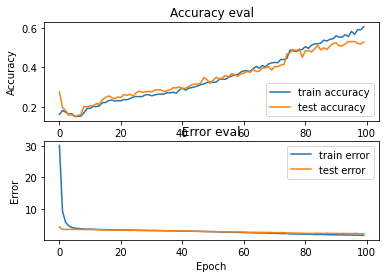

94/94 - 0s - loss: 2.1210 - accuracy: 0.5130 - 134ms/epoch - 1ms/step

Test accuracy: 0.5130173563957214


In [16]:
# train model
history = mlp.fit(X_train, y_train, 
                  validation_data=(X_val, y_val), 
                  batch_size=32, 
                  epochs=100,
                  callbacks = [saveBest, es, lr]
                 )

# plot accuracy and error as a function of the epochs
plot_history(history)

# evaluate model on test set
test_loss, test_acc = mlp.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

## Convolutional Neural Network Model

In [17]:
# reshape for the CNN
X_train_cnn = X_train[..., np.newaxis]
X_val_cnn = X_val[..., np.newaxis]
X_test_cnn = X_test[..., np.newaxis]

### Build CNN Model ###
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# build network topology
cnn = keras.Sequential()

# 1st conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 2nd conv layer
cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# 3rd conv layer
cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
cnn.add(keras.layers.BatchNormalization())

# flatten output and feed it into dense layer
cnn.add(keras.layers.Flatten())
cnn.add(keras.layers.Dense(64, activation='relu'))
cnn.add(keras.layers.Dropout(0.3))

# output layer
cnn.add(keras.layers.Dense(len(genres), activation='softmax'))

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.001)
cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn.summary()

MODEL_SAVE_PATH = MODEL_PATH + "/gtzan_cnn/"
saveBest, es, lr = setup_callbacks(cnn, MODEL_SAVE_PATH)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 6, 32)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 64, 6, 32)        128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 2, 32)        0         
 2D)                                                             
                                                      

Epoch 1/30
150/153 [============================>.] - ETA: 0s - loss: 1.8756 - accuracy: 0.3817
Epoch 1: val_loss improved from inf to 1.62766, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 20ms/step - loss: 1.8667 - accuracy: 0.3834 - val_loss: 1.6277 - val_accuracy: 0.4387 - lr: 0.0010
Epoch 2/30
152/153 [============================>.] - ETA: 0s - loss: 1.3405 - accuracy: 0.5214
Epoch 2: val_loss improved from 1.62766 to 1.19685, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 1.3428 - accuracy: 0.5214 - val_loss: 1.1969 - val_accuracy: 0.5684 - lr: 0.0010
Epoch 3/30
151/153 [============================>.] - ETA: 0s - loss: 1.1757 - accuracy: 0.5803
Epoch 3: val_loss improved from 1.19685 to 1.18623, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 19ms/step - loss: 1.1754 - accuracy: 0.5794 - val_loss: 1.1862 - val_accuracy: 0.5784 - lr: 0.0010
Epoch 4/30
153/153 [==============================] - ETA: 0s - loss: 1.0533 - accuracy: 0.6280
Epoch 4: val_loss improved from 1.18623 to 1.04316, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 1.0533 - accuracy: 0.6280 - val_loss: 1.0432 - val_accuracy: 0.6266 - lr: 0.0010
Epoch 5/30
149/153 [============================>.] - ETA: 0s - loss: 0.9646 - accuracy: 0.6592
Epoch 5: val_loss improved from 1.04316 to 1.02107, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.9689 - accuracy: 0.6591 - val_loss: 1.0211 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 6/30
153/153 [==============================] - ETA: 0s - loss: 0.8897 - accuracy: 0.6936
Epoch 6: val_loss improved from 1.02107 to 0.99568, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 19ms/step - loss: 0.8897 - accuracy: 0.6936 - val_loss: 0.9957 - val_accuracy: 0.6462 - lr: 0.0010
Epoch 7/30
153/153 [==============================] - ETA: 0s - loss: 0.8251 - accuracy: 0.7112
Epoch 7: val_loss improved from 0.99568 to 0.91826, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.8251 - accuracy: 0.7112 - val_loss: 0.9183 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 8/30
151/153 [============================>.] - ETA: 0s - loss: 0.7606 - accuracy: 0.7413
Epoch 8: val_loss did not improve from 0.91826
153/153 [==============================] - 2s 12ms/step - loss: 0.7619 - accuracy: 0.7413 - val_loss: 0.9922 - val_accuracy: 0.6562 - lr: 0.0010
Epoch 9/30
152/153 [============================>.] - ETA: 0s - loss: 0.7090 - accuracy: 0.7519
Epoch 9: val_loss did not improve from 0.91826
153/153 [==============================] - 2s 12ms/step - loss: 0.7095 - accuracy: 0.7521 - val_loss: 1.0886 - val_accuracy: 0.6648 - lr: 0.0010
Epoch 10/30
149/153 [============================>.] - ETA: 0s - loss: 0.6757 - accuracy: 0.7670
Epoch 10: val_loss did not improve from 0.91826
153/153 [==============================] - 2s 12ms/step - loss: 0.6814 - accuracy: 0.7652 - val_loss: 0.9415 - val_accuracy: 0.6695 - 

INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 18ms/step - loss: 0.5166 - accuracy: 0.8230 - val_loss: 0.9123 - val_accuracy: 0.7139 - lr: 0.0010
Epoch 15/30
152/153 [============================>.] - ETA: 0s - loss: 0.4859 - accuracy: 0.8248
Epoch 15: val_loss did not improve from 0.91227
153/153 [==============================] - 2s 14ms/step - loss: 0.4856 - accuracy: 0.8251 - val_loss: 0.9973 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 16/30
153/153 [==============================] - ETA: 0s - loss: 0.4538 - accuracy: 0.8394
Epoch 16: val_loss improved from 0.91227 to 0.81769, saving model to /storage/graham/music/models//gtzan_cnn/
INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


INFO:tensorflow:Assets written to: /storage/graham/music/models//gtzan_cnn/assets


153/153 [==============================] - 3s 20ms/step - loss: 0.4538 - accuracy: 0.8394 - val_loss: 0.8177 - val_accuracy: 0.7330 - lr: 0.0010
Epoch 17/30
152/153 [============================>.] - ETA: 0s - loss: 0.4431 - accuracy: 0.8413
Epoch 17: val_loss did not improve from 0.81769
153/153 [==============================] - 2s 12ms/step - loss: 0.4423 - accuracy: 0.8414 - val_loss: 0.9076 - val_accuracy: 0.7220 - lr: 0.0010
Epoch 18/30
149/153 [============================>.] - ETA: 0s - loss: 0.4296 - accuracy: 0.8551
Epoch 18: val_loss did not improve from 0.81769
153/153 [==============================] - 2s 12ms/step - loss: 0.4293 - accuracy: 0.8551 - val_loss: 0.9464 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 19/30
151/153 [============================>.] - ETA: 0s - loss: 0.3952 - accuracy: 0.8649
Epoch 19: val_loss did not improve from 0.81769
153/153 [==============================] - 2s 12ms/step - loss: 0.3985 - accuracy: 0.8637 - val_loss: 0.9808 - val_accuracy: 0.705

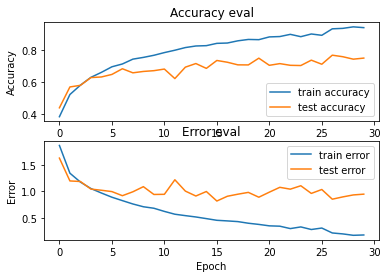

94/94 - 0s - loss: 0.9952 - accuracy: 0.7340 - 437ms/epoch - 5ms/step

Test accuracy: 0.7339786291122437


In [18]:
# train model
history = cnn.fit(X_train_cnn, y_train, 
                  validation_data=(X_val_cnn, y_val), 
                  batch_size=32, 
                  epochs=30,
                  callbacks = [saveBest, es, lr]
                 )

# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)